In [1]:
import pandas as pd
import numpy as np

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ealaxi/paysim1

mkdir: cannot create directory ‘/root/.kaggle’: File exists
paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip paysim1.zip

Archive:  paysim1.zip
replace PS_20174392719_1491204439457_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PS_20174392719_1491204439457_log.csv  y



In [18]:
df =pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [19]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from tqdm import tqdm

In [9]:
pip install sweetviz

                                             |          | [  0%]   00:00 -> (? left)


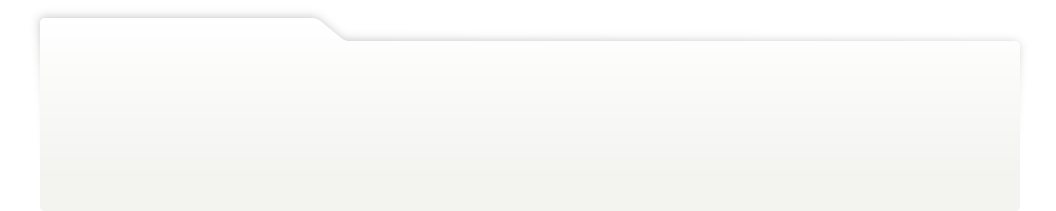
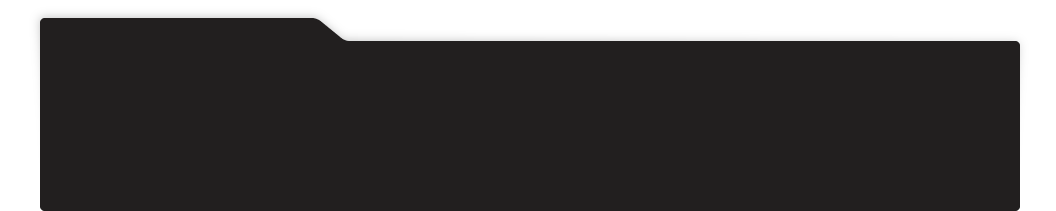
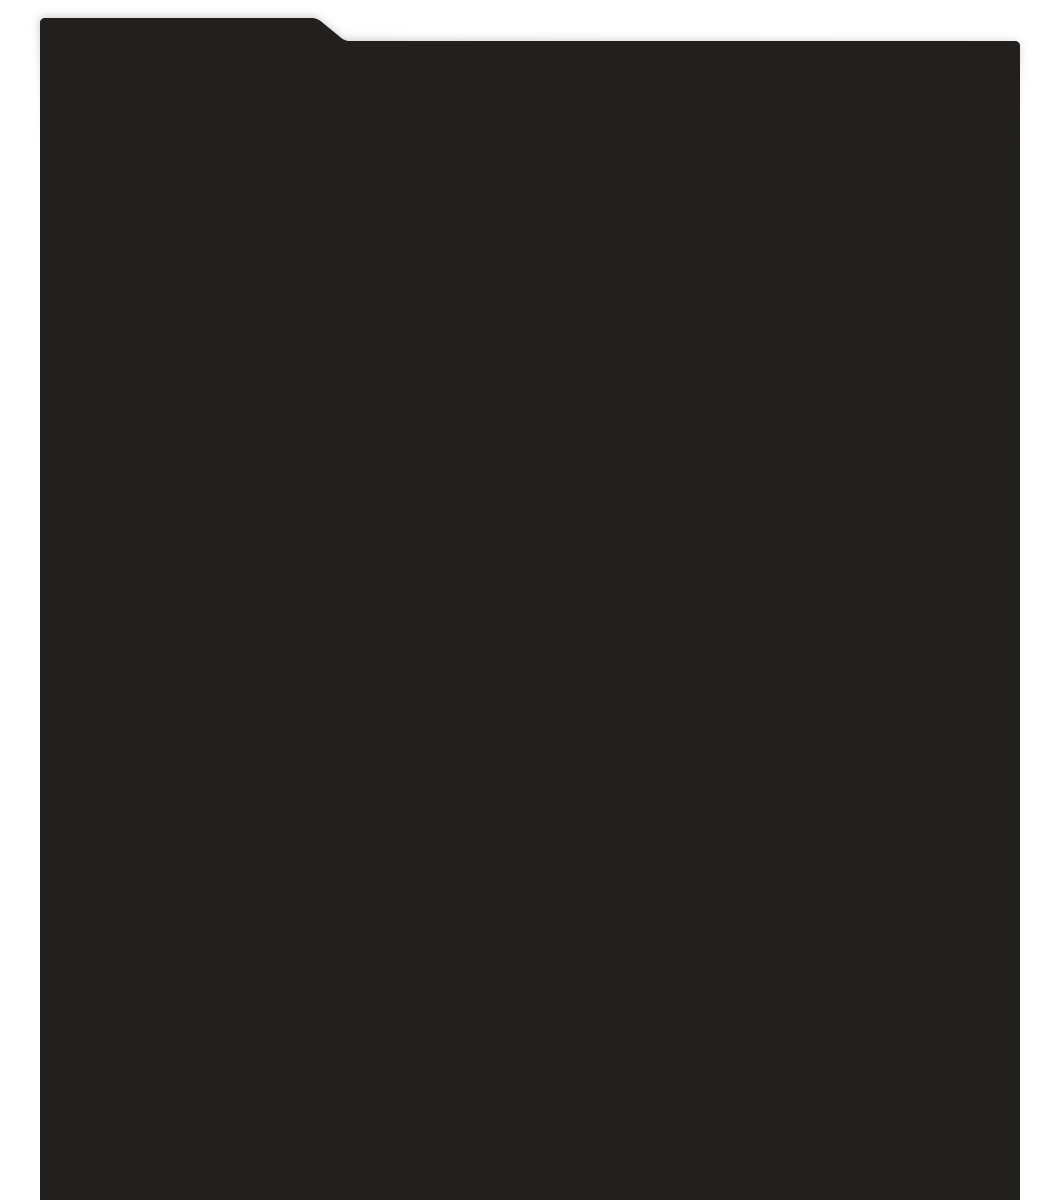
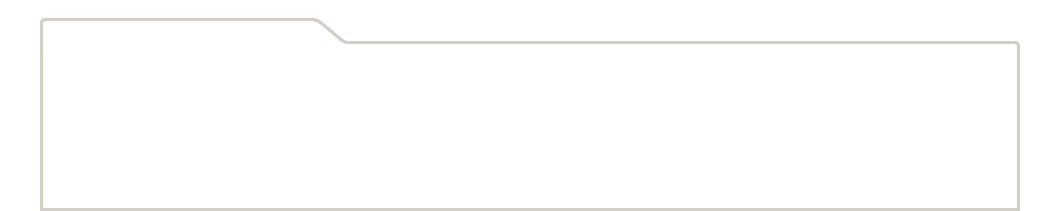
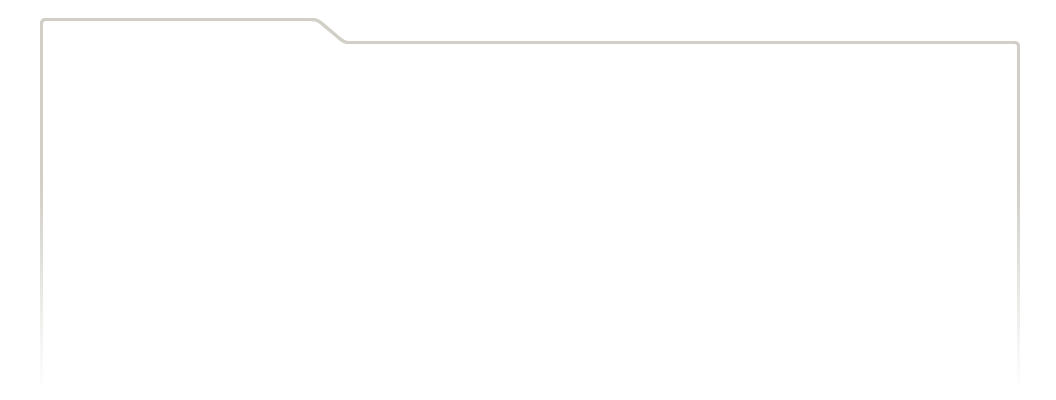
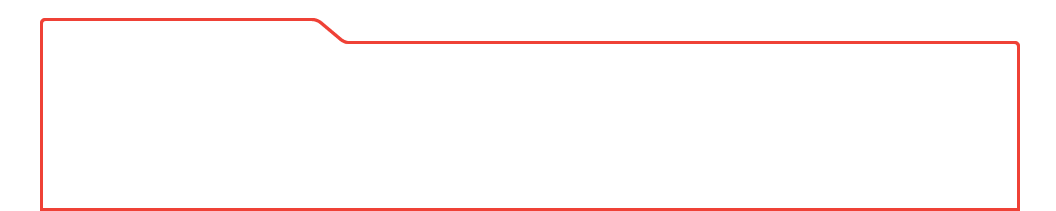
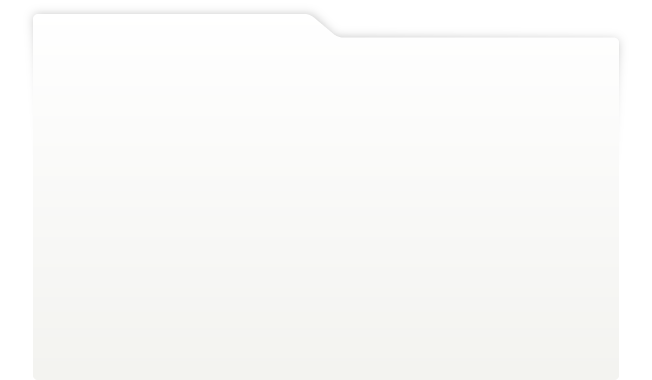
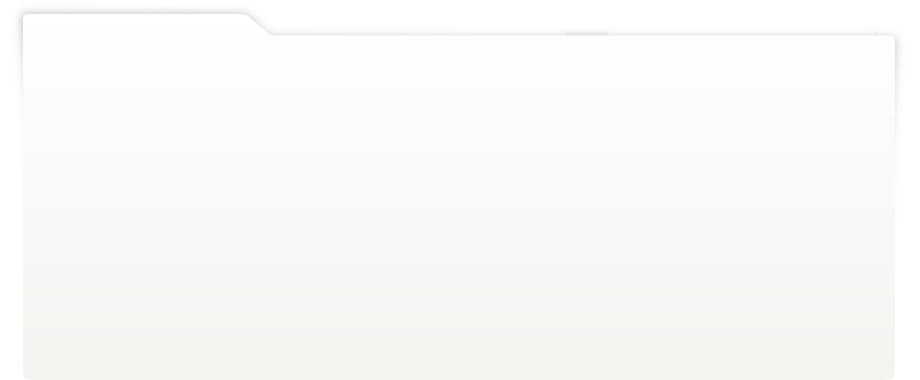
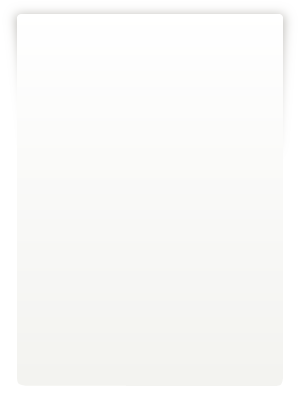
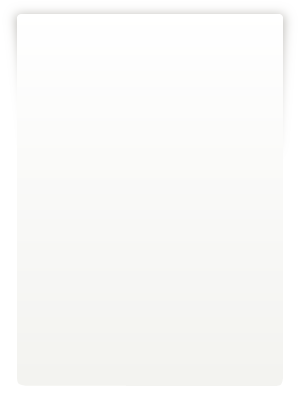
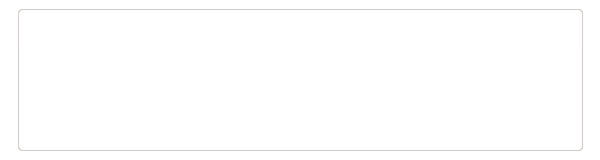
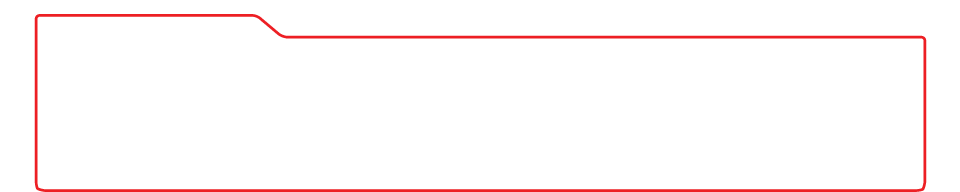
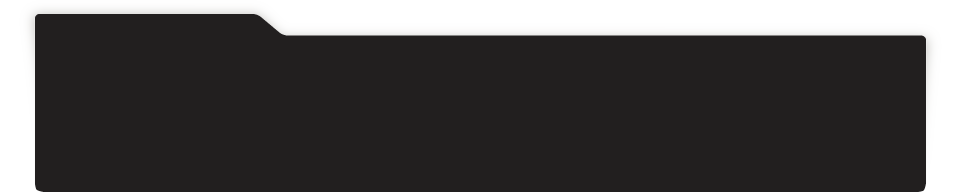
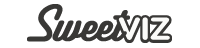
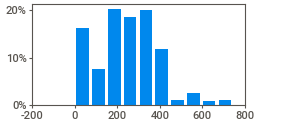
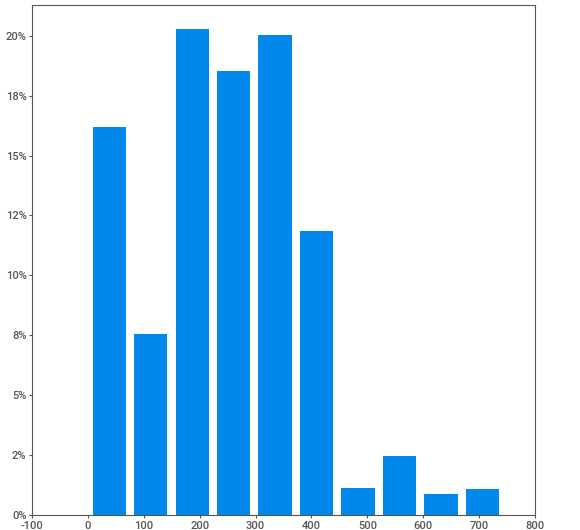
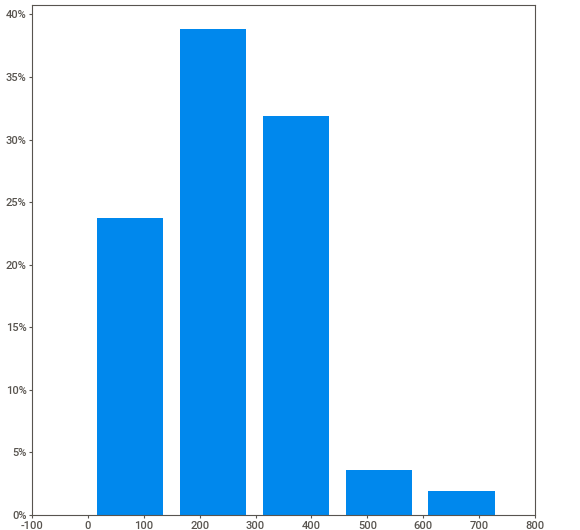
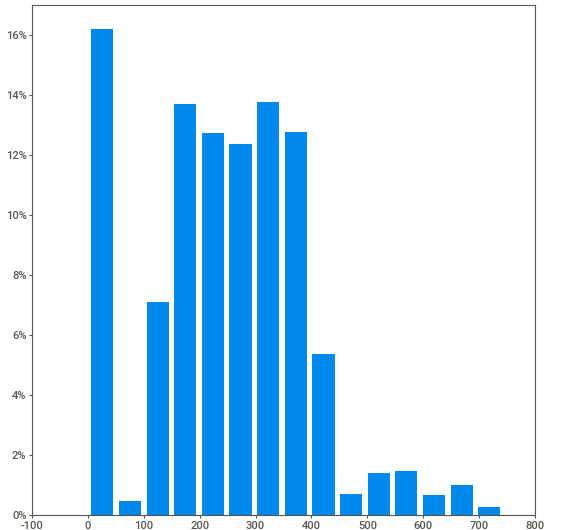
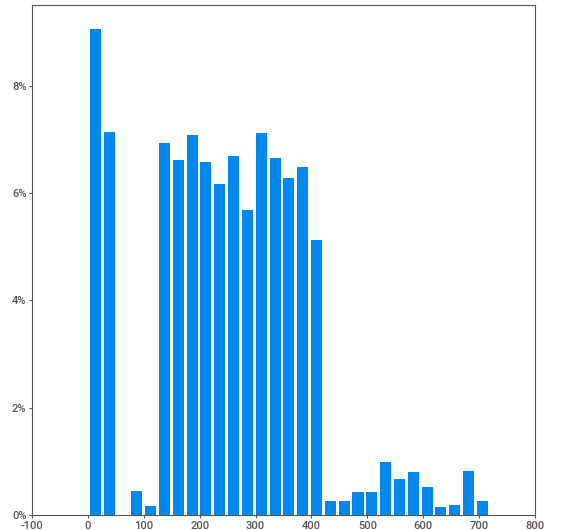
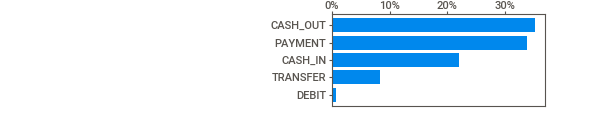
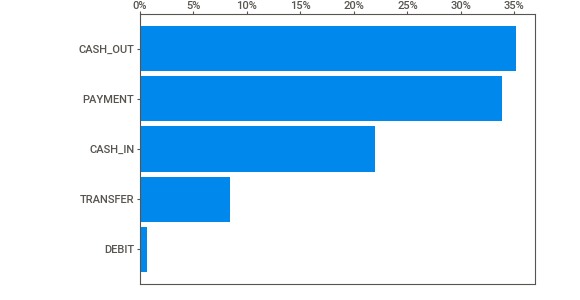
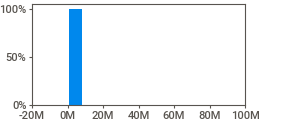
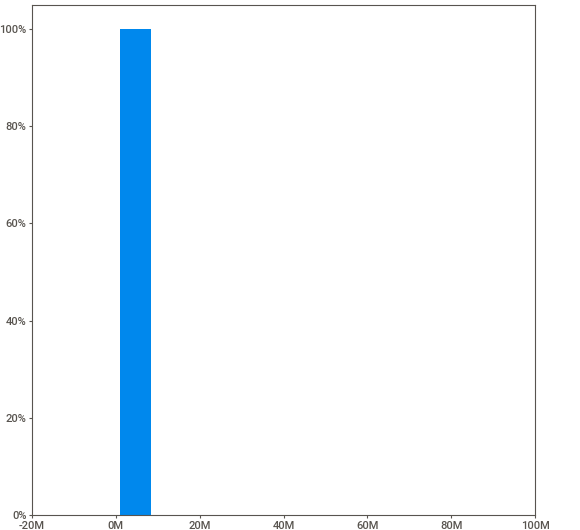
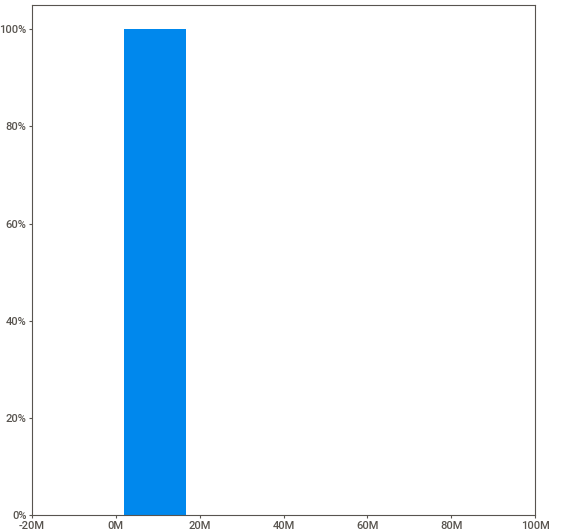
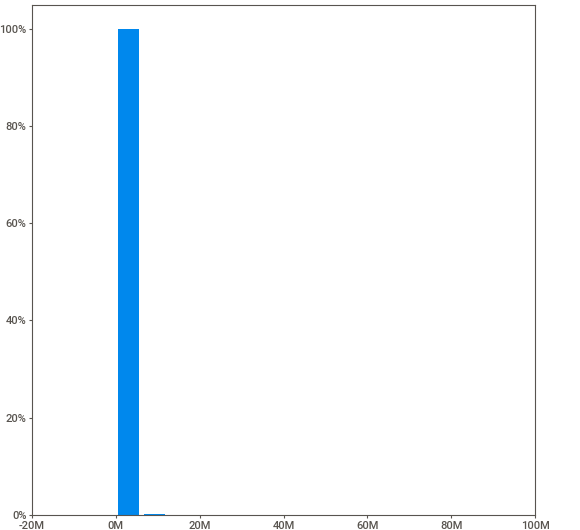
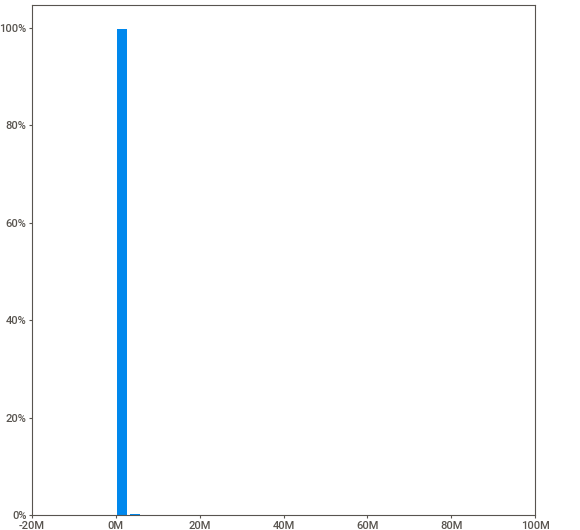
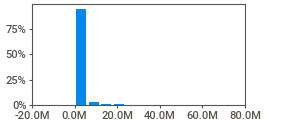
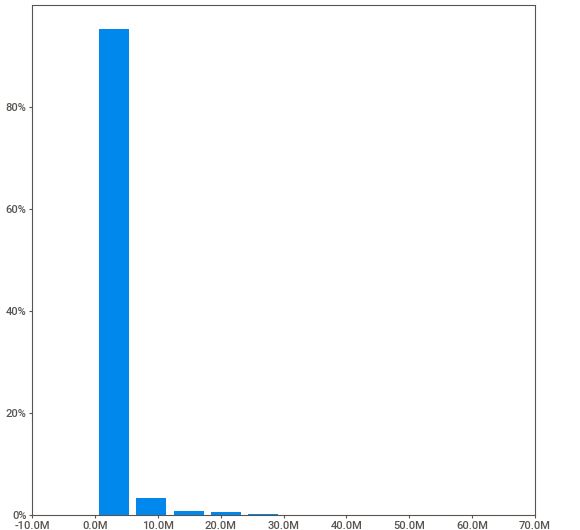
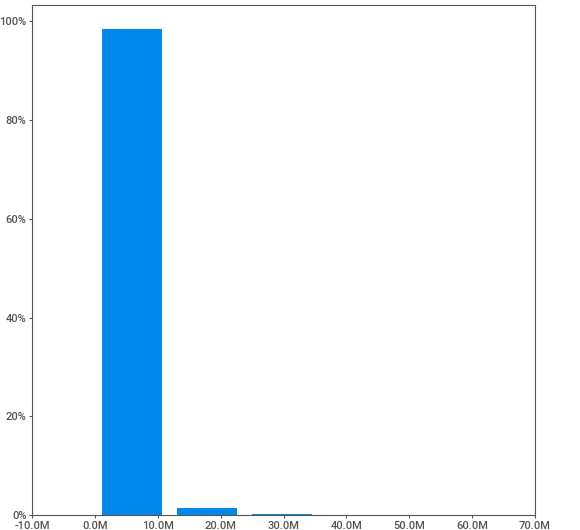
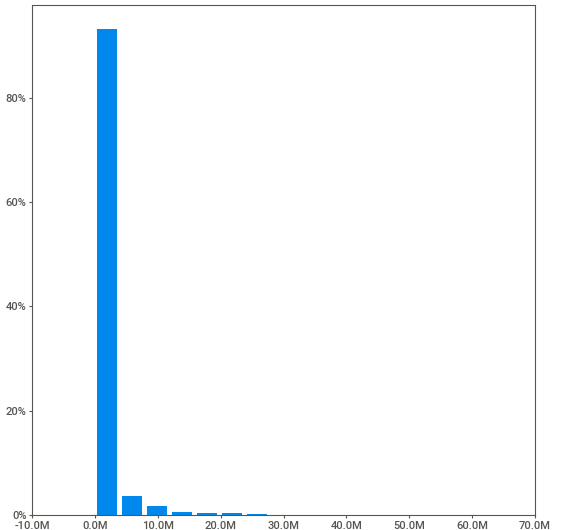
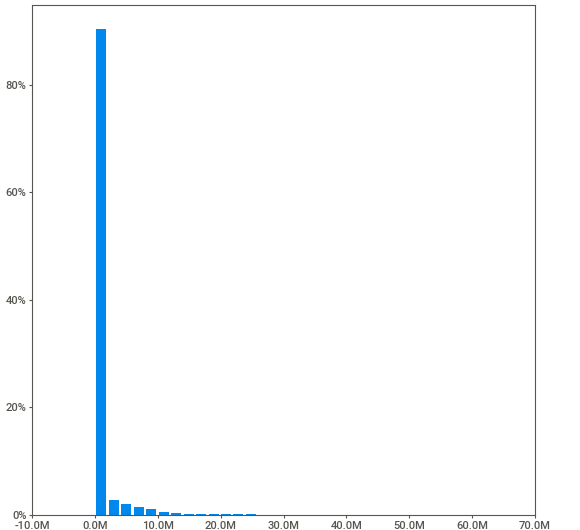
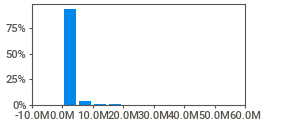
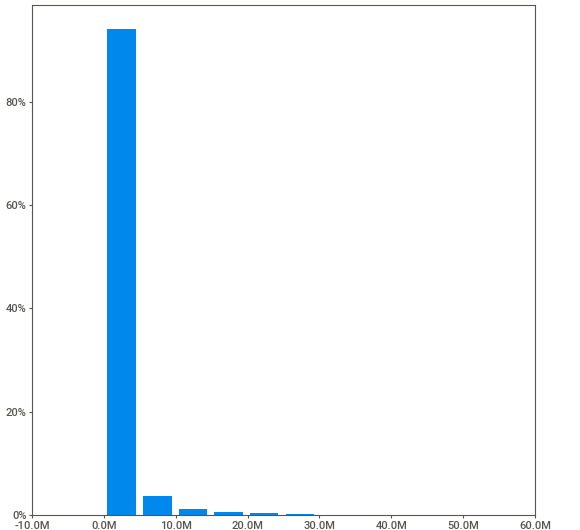
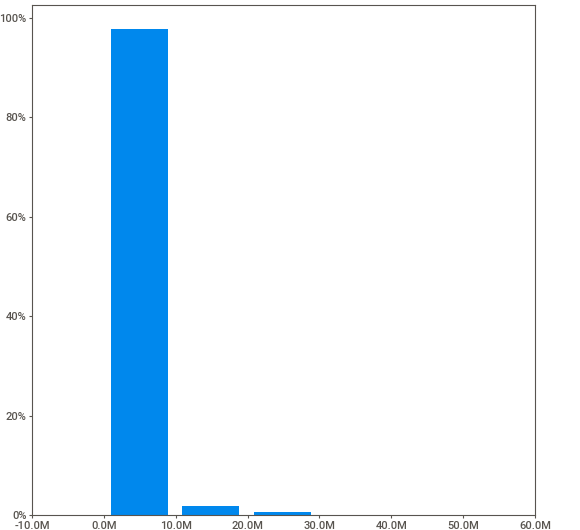
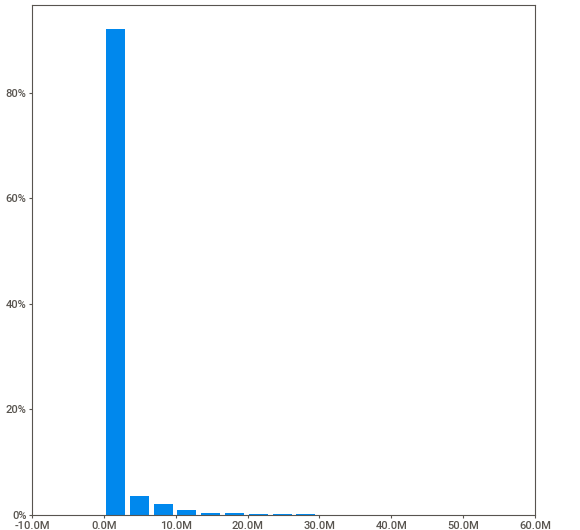
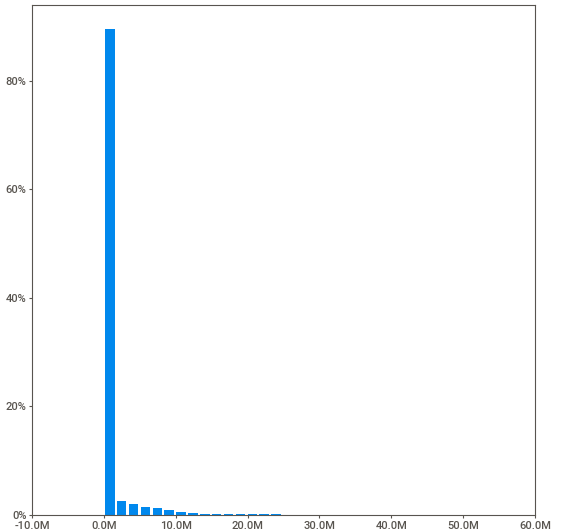
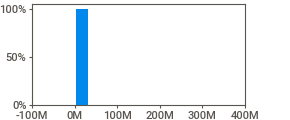
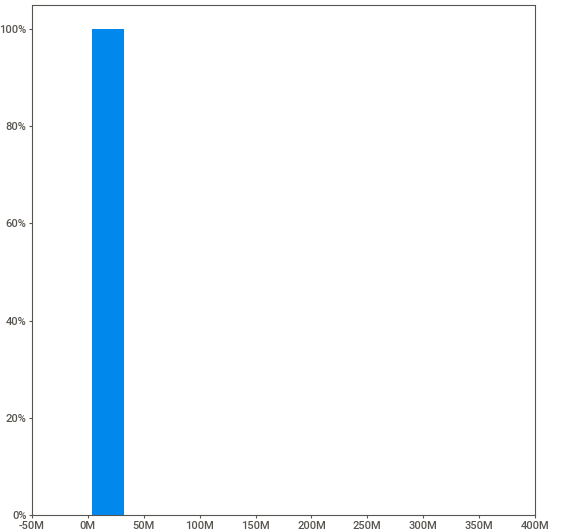
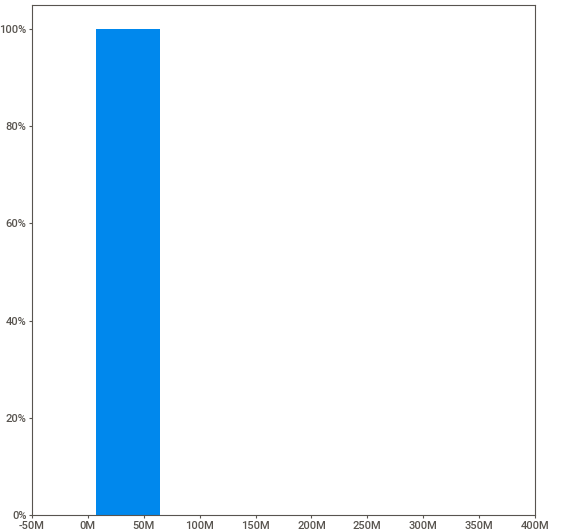
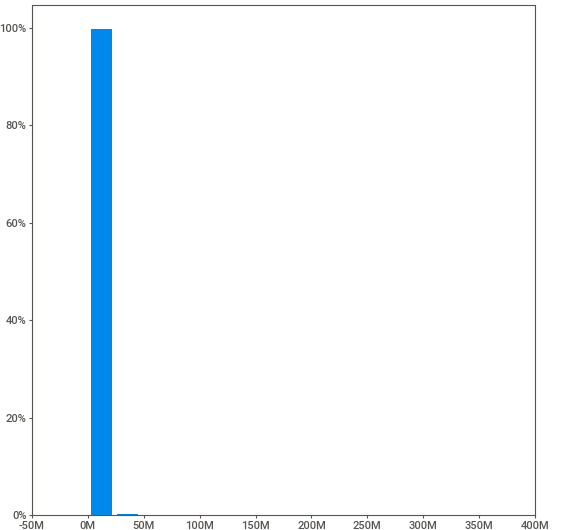
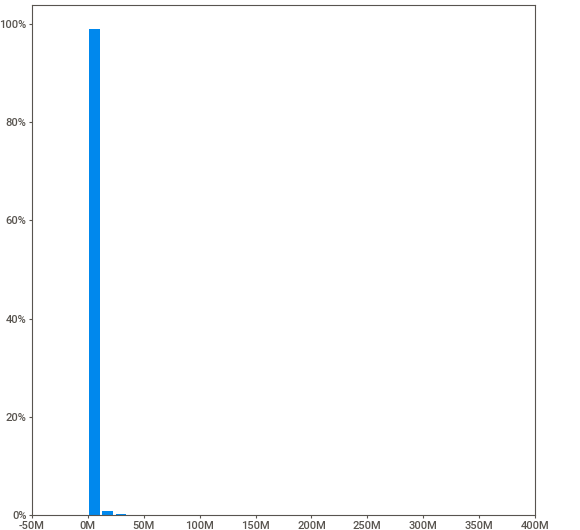
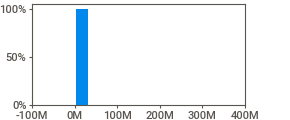
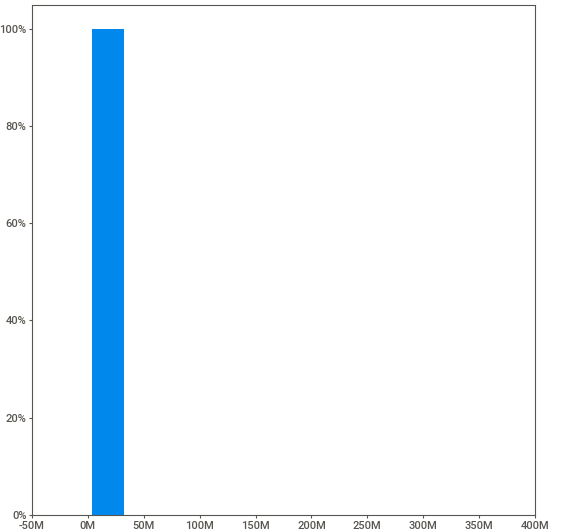
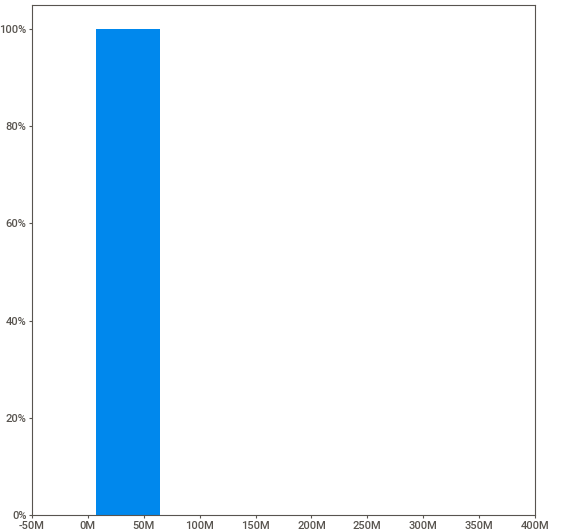
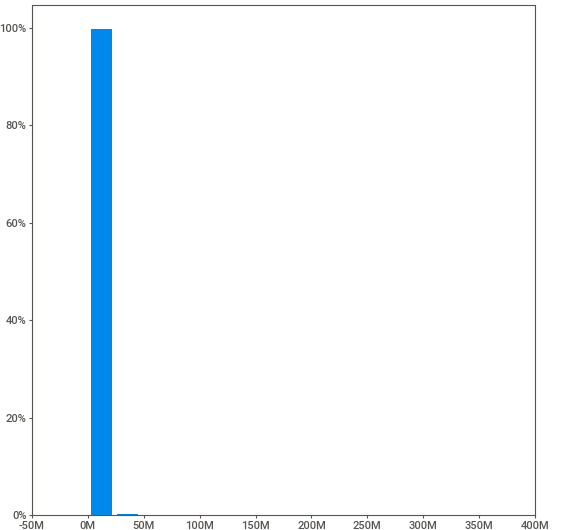
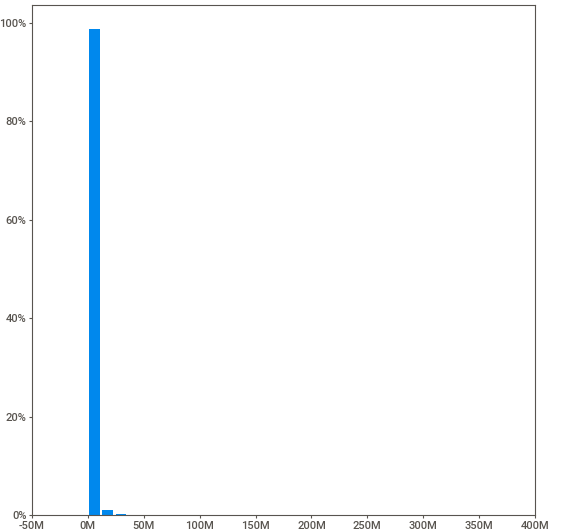
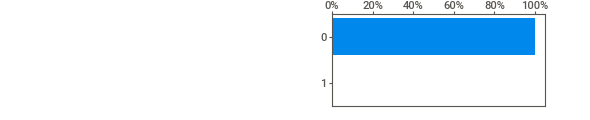
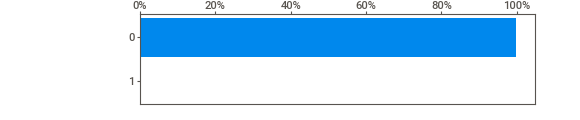
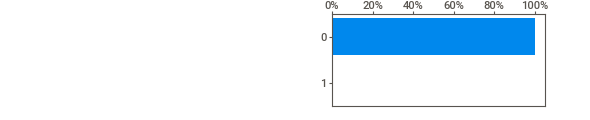
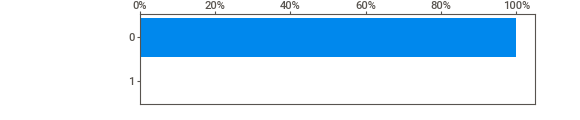
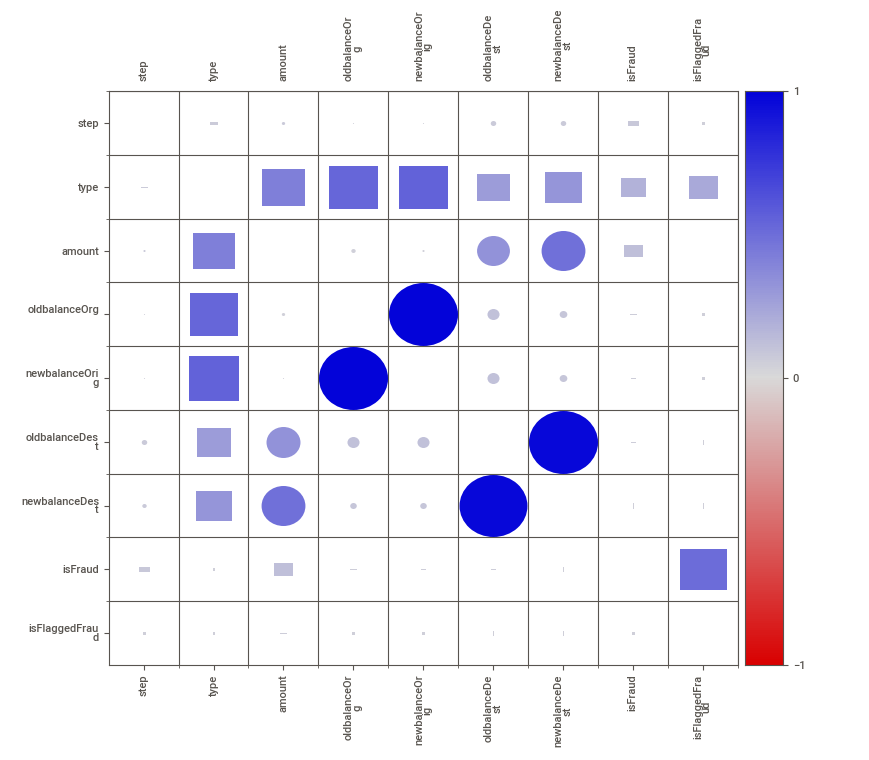
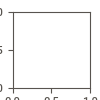

In [10]:

import sweetviz as sv
advert_report = sv.analyze(df)
advert_report.show_notebook()

In [20]:
df1 = df.loc[df['isFraud'] == 1]

In [21]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [22]:
df2 = df[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')]

In [23]:
len(df2)

2770409

In [24]:
df2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [27]:
df2['Fraud Detected'] = np.where(((df2['type'] == 'TRANSFER') & (df2['amount'] > 200000)),1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df2['Fraud Detected']

2          0
3          0
15         0
19         1
24         1
          ..
6362615    0
6362616    1
6362617    0
6362618    1
6362619    0
Name: Fraud Detected, Length: 2770409, dtype: int64

In [30]:
df2['Fraud Detected'].sum()

409110

In [32]:
100 * (df2['Fraud Detected'].sum()/len(df2))

14.76713366149186

In [33]:
from sklearn.metrics import f1_score

In [35]:
100 * (f1_score(y_pred=df2['Fraud Detected'],y_true=df2['isFraud']))

1.3131315551742895

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=df2['Fraud Detected'],y_true=df2['isFraud'])

In [40]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.png')
    plt.show()

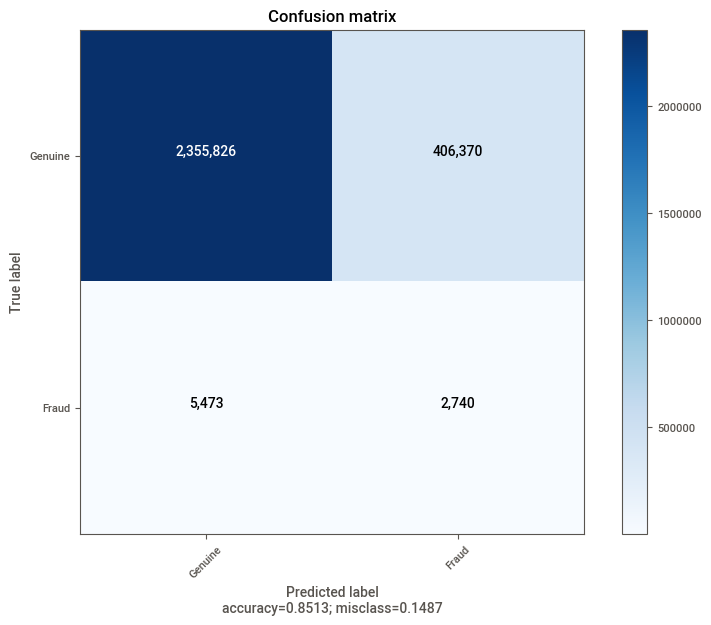

In [41]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [47]:
df2['hour'] = df2['step'] % 24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
df2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud Detected,hour
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


In [49]:
df2['type'] = 'type_' + df2['type'].astype(str)
dummies = pd.get_dummies(df2['type'])
df2 = pd.concat([df2,dummies],axis=1)
del df2['type']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
df2 = df2.drop(['nameOrig','nameDest','Fraud Detected'], axis= 1)

In [52]:
df2['Night'] = np.where((2 <= df2['hour']) & (df2['hour'] <= 6), 1,0)

In [54]:
df2[df2['Night'] == 1].isFraud.mean()

0.35705263157894734

In [56]:
df2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_OUT,type_TRANSFER,Night
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1,0,1,0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,0,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,0,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,0,1,0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,0,1,0


In [57]:
df2 = df2.drop(['step','hour'],axis=1)

In [58]:
df2.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,Night
2,181.00,181.0,0.0,0.0,0.00,1,0,0,1,0
3,181.00,181.0,0.0,21182.0,0.00,1,0,1,0,0
15,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0,0
19,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1,0


In [64]:
y_df2 = df2['isFraud']
x_df2 = df2.drop('isFraud',axis=1)

In [65]:

y = y_df2.values
X = x_df2.values

In [66]:

y.shape

(2770409,)

In [67]:

X.shape

(2770409, 9)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [71]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [72]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

In [75]:
model = Sequential()
model.add(Dense(1, input_dim=9))
model.add(Activation('sigmoid'))

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 10        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5), 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [78]:
model.fit(X_train_res,y_train_res,
          epochs=5, 
          batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/5
13013/13013 [==============================] - 17s 1ms/step - loss: 815747.3750 - acc: 0.9000 - val_loss: 153236.5312 - val_acc: 0.9311
Epoch 2/5
13013/13013 [==============================] - 16s 1ms/step - loss: 755089.1250 - acc: 0.9067 - val_loss: 238657.8750 - val_acc: 0.9010
Epoch 3/5
13013/13013 [==============================] - 17s 1ms/step - loss: 755486.5000 - acc: 0.9066 - val_loss: 124474.3516 - val_acc: 0.9408
Epoch 4/5
13013/13013 [==============================] - 16s 1ms/step - loss: 762537.8750 - acc: 0.9070 - val_loss: 329400.9062 - val_acc: 0.8795
Epoch 5/5
13013/13013 [==============================] - 16s 1ms/step - loss: 755343.6250 - acc: 0.9071 - val_loss: 130428.6875 - val_acc: 0.9337


In [79]:
y_pred = model.predict(X_test)

In [82]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [83]:
f1_score(y_pred=y_pred,y_true=y_test)

0.07637583286958352

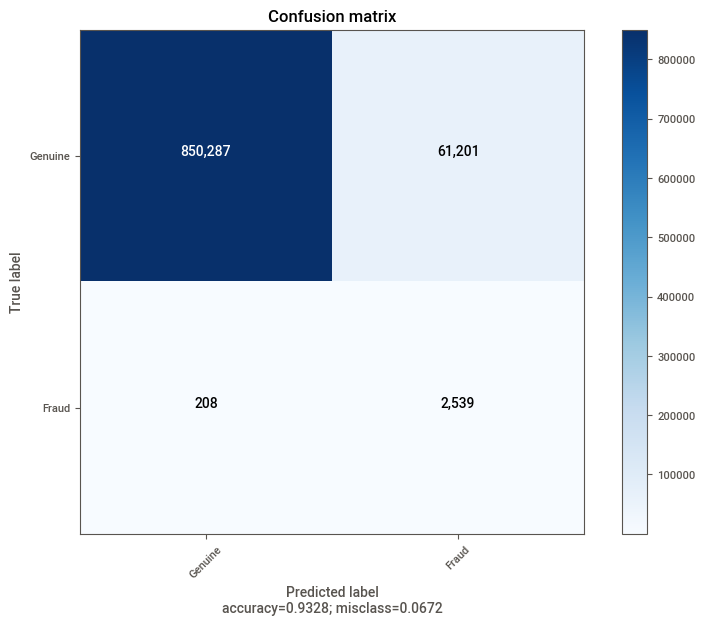

In [84]:

cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [89]:
model = Sequential()
model.add(Dense(16,input_dim=9))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [91]:
model.compile(loss='binary_crossentropy',optimizer=SGD(learning_rate=1e-4), metrics=['acc'])

In [92]:
model.fit(X_train_res,y_train_res,
          epochs=5, batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/5
13013/13013 [==============================] - 17s 1ms/step - loss: 0.4489 - acc: 0.8609 - val_loss: 0.3518 - val_acc: 0.9283
Epoch 2/5
13013/13013 [==============================] - 18s 1ms/step - loss: 0.3880 - acc: 0.8625 - val_loss: 0.4356 - val_acc: 0.8200
Epoch 3/5
13013/13013 [==============================] - 17s 1ms/step - loss: 0.3900 - acc: 0.8578 - val_loss: 0.3159 - val_acc: 0.9434
Epoch 4/5
13013/13013 [==============================] - 17s 1ms/step - loss: 0.3742 - acc: 0.8616 - val_loss: 0.3045 - val_acc: 0.9606
Epoch 5/5
13013/13013 [==============================] - 17s 1ms/step - loss: 0.3830 - acc: 0.8714 - val_loss: 0.3246 - val_acc: 0.9350


In [93]:
y_pred = model.predict(X_test)

In [94]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [95]:
f1_score(y_pred=y_pred,y_true=y_test)

0.07073734157457702

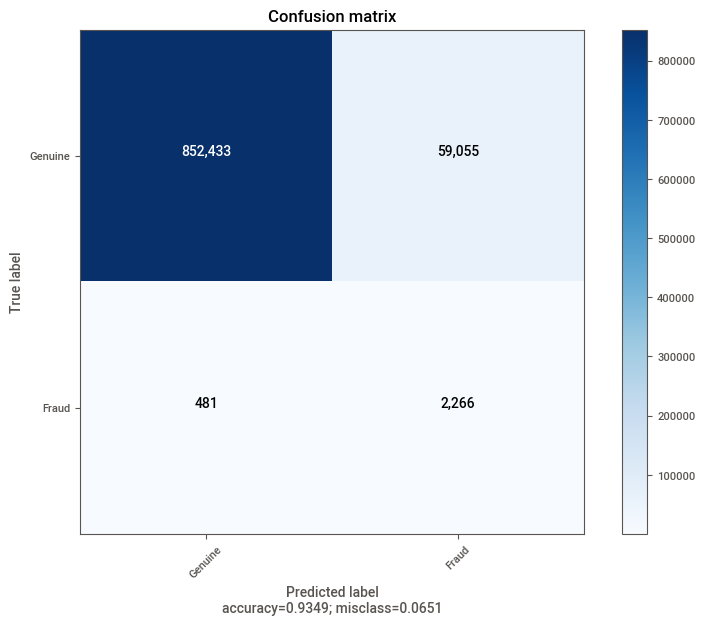

In [96]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [97]:
from sklearn.ensemble import  RandomForestClassifier

In [98]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [99]:
y_pred = rf.predict(X_test)

In [100]:
f1_score(y_pred=y_pred,y_true=y_test)

0.8776321017083829

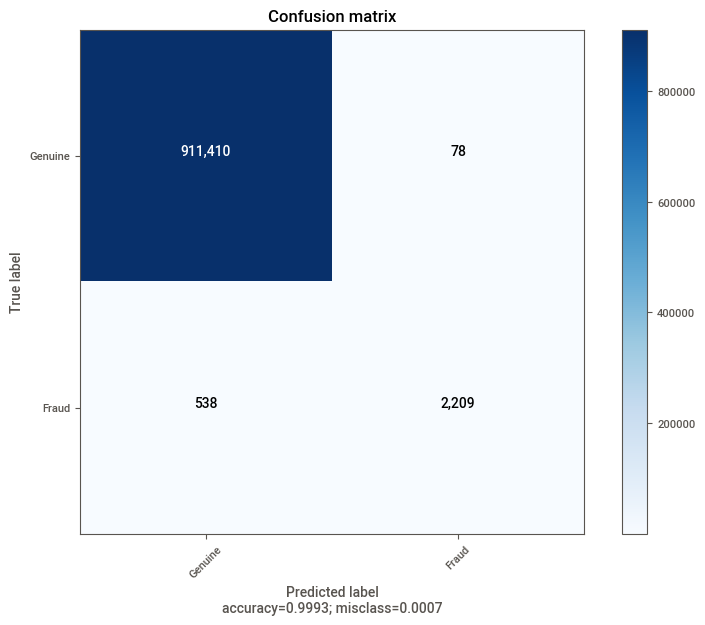

In [101]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [102]:

import xgboost as xgb
booster = xgb.XGBClassifier(n_jobs=-1)
booster = booster.fit(X_train,y_train)
y_pred = booster.predict(X_test)

In [103]:
f1_score(y_pred=y_pred,y_true=y_test)

0.8557295960428689

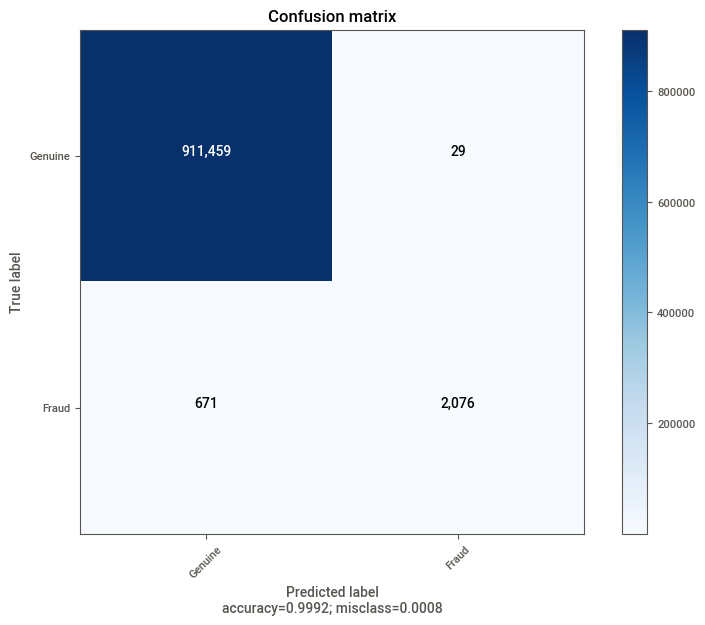

In [104]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)